Elad Inbar - 205358211 Ido Livne - 203834733 Chai Hadad - 209268135

# **Import**

In [26]:
import csv
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import pprint as pp
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import sklearn
from sklearn import tree
from sklearn import impute
import itertools
import time

# **Initialize Runtime**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# **Define dataset paths**

In [3]:
protocol_path = 'PAMAP2_Dataset/Protocol/'
optional_path = 'PAMAP2_Dataset/Optional/'

protocol_dir = sorted(os.listdir(protocol_path))
optional_dir = sorted(os.listdir(optional_path))

# **Exploratory Data Analysis**

In [4]:
optional_subjects = ["subject101", "subject105", "subject106", "subject108", "subject109"]
protocol_subjects = ["subject101", "subject102", "subject103", "subject104", "subject105", "subject106", "subject107", "subject108", "subject109"]

## Creating CSV Files 
In this section we will create a csv files out of the .dat files. It is easier to work with csv file, read it and update it. 
In addition, the files contains some irrelevant data and missing data. In order to combat this issue, we will delete that data columns we wouldn't like to work with and fill/impute missing data

In [37]:
protocol_dat_content = [[i.strip().split() for i in open(protocol_path + protocol_subject + ".dat").readlines()] for protocol_subject in protocol_subjects]

In [ ]:
optional_dat_content = [[i.strip().split() for i in open(optional_path + optional_subject + ".dat").readlines()] for optional_subject in optional_subjects]   

In [ ]:
for i in range(9):
    with open(protocol_path + protocol_subjects[i] + ".csv", "w") as file:
        writer = csv.writer(file)
        writer.writerows(protocol_dat_content[i])

In [ ]:
for i in range(5):
    with open(optional_path + optional_subjects[i] + ".csv", "w") as file:
        writer = csv.writer(file)
        writer.writerows(optional_dat_content[i])

### updates refill heart rate
Because the Heart Rate is measured every 9Hz in contrast to the other metrics that were measures every 100Hz, we will have to fill the heart rate values. we will fill it with the previous known value. 

In [ ]:
def find_first_val(subject_path_csv):
    indexs_names = [i for i in range(54)]
    df1 =  pd.read_csv(subject_path_csv, names=indexs_names)
    for c,i in enumerate(df1[2]):
        if not math.isnan(i):
            return i
    print("somehow - couldn't find first value")
    return -1
    
    
def fill_heart_rate(subject_path_csv):
    print(f'updating {subject_path_csv}')
    indexs_names = [i for i in range(54)]
    df1 =  pd.read_csv(subject_path_csv, names=indexs_names)
    prev_val = find_first_val(subject_path_csv)
    for c,i in enumerate(df1[2]):
        if not math.isnan(i):
            prev_val = i
        else:
            df1[2][c] = prev_val
        if c%100000 == 0:
            print(f'done {c} / {len(df1[0])}')
    df1.to_csv(subject_path_csv, index=False, header=False)
    
for protocol_subject in protocol_subjects:
    fill_heart_rate(protocol_path + protocol_subject + ".csv")
    
for optional_subject in optional_subjects:
    fill_heart_rate(optional_path + optional_subject + ".csv")

in the code section below we keep only the relevant data columns. 

In [ ]:
for idx, protocol_subject in enumerate(protocol_subjects):
    input = open(protocol_path + protocol_subject + ".csv", 'r')
    output = open(protocol_path + protocol_subject + "_edited.csv", 'w')
    writer = csv.writer(output)
    for row in csv.reader(input):
        if row[1]!='0':
            writer.writerow((row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[20],row[21],row[22],row[23],row[24],row[25],row[26],row[27],row[28],row[29],row[30],row[31],row[32],row[37],row[38],row[39],row[40], row[41],row[42],row[43],row[44],row[45],row[46],row[47],row[48],row[49]))
    input.close()
    output.close()
    print(f"finished {protocol_subject}")


In [ ]:
for idx, optional_subject in enumerate(optional_subjects):
    input = open(optional_path + optional_subject + ".csv", 'r')
    output = open(optional_path + optional_subject + "_edited.csv", 'w')
    writer = csv.writer(output)
    for row in csv.reader(input):
        if row[1]!='0':
            writer.writerow((row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[20],row[21],row[22],row[23],row[24],row[25],row[26],row[27],row[28],row[29],row[30],row[31],row[32],row[37],row[38],row[39],row[40], row[41],row[42],row[43],row[44],row[45],row[46],row[47],row[48],row[49]))
    input.close()
    output.close()
    print(f"finished {optional_subject}")

## Imputing Data Frame
because some of the data is missing, we will impute the NaN values. we use regional average as imputing strategy. 

In [5]:
columns_to_keep = ['timestamp (s)', 'activityID', 'heart rate (bpm)'] # (1, 2, 3)

# 4-20 (3-19)
columns_to_keep += ['IMU hand temperature (°C)'] # 1 (3)
columns_to_keep += ['IMU hand 3D-acceleration data (ms-2), scale +-16g ' + str(i + 1) for i in range(3)] # 2-4 (4-6)
columns_to_keep += ['IMU hand 3D-acceleration data (ms-2), scale +-6g ' + str(i + 1) for i in range(3)] # 5-7 (7-9)
columns_to_keep += ['IMU hand 3D-gyroscope data (rad/s) ' + str(i + 1) for i in range(3)] # 8-10 (10-12)
columns_to_keep += ['IMU hand 3D-magnetometer (µT) ' + str(i + 1) for i in range(3)] # 11-13 (13-15)

# 21-37 (20-36)
columns_to_keep += ['IMU chest temperature (°C)'] # 1 (20)
columns_to_keep += ['IMU chest 3D-acceleration data (ms-2), scale +-16g ' + str(i + 1) for i in range(3)] # 2-4 (21-23)
columns_to_keep += ['IMU chest 3D-acceleration data (ms-2), scale +-6g ' + str(i + 1) for i in range(3)] # 5-7 (24-26)
columns_to_keep += ['IMU chest 3D-gyroscope data (rad/s) ' + str(i + 1) for i in range(3)] # 8-10 (27-29)
columns_to_keep += ['IMU chest 3D-magnetometer (µT) ' + str(i + 1) for i in range(3)] # 11-13 (30-32)

# 38-54 (37-53)
columns_to_keep += ['IMU ankle temperature (°C)'] # 1 (37)
columns_to_keep += ['IMU ankle 3D-acceleration data (ms-2), scale +-16g ' + str(i + 1) for i in range(3)] # 2-4 (38-40)
columns_to_keep += ['IMU ankle 3D-acceleration data (ms-2), scale +-6g ' + str(i + 1) for i in range(3)] # 5-7 (41-43)
columns_to_keep += ['IMU ankle 3D-gyroscope data (rad/s) ' + str(i + 1) for i in range(3)] # 8-10 (44-46)
columns_to_keep += ['IMU ankle 3D-magnetometer (µT) ' + str(i + 1) for i in range(3)] # 11-13 (47-49)

## refill NaN values with imputation

In [ ]:
protocol_dataframes = {}
for protocol_subject in protocol_subjects:
    print(f'updating NaN values for {protocol_subject}')
    curr_df = pd.read_csv(protocol_path + protocol_subject + "_edited.csv", names=columns_to_keep)
    imputer = impute.SimpleImputer(strategy='mean')
    X = curr_df.values
    imputer.fit(X)
    x_imputed = imputer.transform(X)
    curr_df[:] = x_imputed 
    protocol_dataframes[protocol_subject] = curr_df 

## Data functions

In [7]:
def get_activity_name_by_id(id, for_plot=True):
    id_to_names = {}
    id_to_names[1] = 'lying'
    id_to_names[2] = 'sitting'
    id_to_names[3] = 'standing'
    id_to_names[4] = 'walking'
    id_to_names[5] = 'running'
    id_to_names[6] = 'cycling'
    id_to_names[7] = 'Nordic\nwalking' if for_plot else 'Nordic walking'
    id_to_names[9] = 'watching\nTV' if for_plot else 'watching TV'
    id_to_names[10] = 'computer\nwork' if for_plot else 'computer work'
    id_to_names[11] = 'car\ndriving' if for_plot else 'car driving'
    id_to_names[12] = 'ascending\nstairs' if for_plot else 'ascending stairs'
    id_to_names[13] = 'descending\nstairs' if for_plot else 'descending stairs'
    id_to_names[16] = 'vacuum\ncleaning' if for_plot else 'vacuum cleaning'
    id_to_names[17] = 'ironing'
    id_to_names[18] = 'folding\nlaundry' if for_plot else 'folding laundry'
    id_to_names[19] = 'house\ncleaning' if for_plot else 'house cleaning'
    id_to_names[20] = 'playing\nsoccer' if for_plot else 'playing soccer'
    id_to_names[24] = 'rope\njumping' if for_plot else 'rope jumping'
    id_to_names[0] = 'other'
    return id_to_names[id]

all_activity_list = ['lying','sitting','standing','walking','running','cycling','Nordic walking','watching TV','computer work','car driving','ascending stairs','descending stairs','vacuum cleaning','ironing','folding laundry','house cleaning','playing soccer','rope jumping']
protocol_activity_list = ['lying','sitting','standing','walking','running','cycling','Nordic walking','ascending stairs','descending stairs','vacuum cleaning','ironing','rope jumping']

In order to get a better understading of our dataset and its contents. We would like to take a look of the amount of activities preformed. By that we can understand the distribution of activities.

In [10]:
def count_activities_per_subject(subject_df):
    acts_values_unfiltered = subject_df['activityID'].tolist()
    acts_values = []
    for i in range(len(acts_values_unfiltered)):
        if i == 0 or acts_values_unfiltered[i-1] != acts_values_unfiltered[i] :
            acts_values.append(acts_values_unfiltered[i]) 
    acts_set = set(acts_values)
    res = {}
    for act in acts_set:
        if act != 0:
            res[act] = 0
    for act in acts_values:
        if act != 0:
            res[act] = res[act] + 1
    return res

In [11]:
activity_count = {}
for protocol_subject in protocol_subjects:
    temp_acts = count_activities_per_subject(protocol_dataframes[protocol_subject])
    for key in temp_acts.keys():
        if key in activity_count.keys():
            activity_count[key] += temp_acts[key]
        else:
            activity_count[key] = temp_acts[key]


In [ ]:
values = activity_count

keys_lst = []
count_lst = []
for key in values.keys():
    keys_lst.append(key)
    count_lst.append(values[key])

activity_names = [get_activity_name_by_id(act_id) for act_id in keys_lst]

fig, ax = plt.subplots()
fig.set_size_inches(20, 10.5)

bar_labels = keys_lst
ax.bar(activity_names, count_lst)
ax.set_ylabel('activity measures amount')
ax.set_title('activity name')

plt.show()

## Activity Sensors Plot

In [ ]:
# Jupyter Notebook
# Set notebook mode to work in offline
pyo.init_notebook_mode()

### Running plot

In [147]:
def plot_range_by_activate(subject, df_of_subject, activity, columns_to_plot):
    df = df_of_subject[df_of_subject['activityID'] == activity] 
    df.drop(['activityID'], axis=1, inplace=True)
    df = df[columns_to_plot]
    fig = px.line(df, x='timestamp (s)', y=df.columns,
              title=subject + ' activity: ' + str(activity))
    fig.show()

In [148]:
columns_to_keep_labels = ['timestamp (s)', 'heart rate (bpm)']

columns_to_keep_labels += ['IMU hand temperature (°C)']
columns_to_keep_labels += ['IMU hand 3D-acceleration data (ms-2), scale +-16g ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU hand 3D-acceleration data (ms-2), scale +-6g ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU hand 3D-gyroscope data (rad/s) ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU hand 3D-magnetometer (µT) ' + str(i + 1) for i in range(3)]

columns_to_keep_labels += ['IMU chest temperature (°C)']
columns_to_keep_labels += ['IMU chest 3D-acceleration data (ms-2), scale +-16g ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU chest 3D-acceleration data (ms-2), scale +-6g ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU chest 3D-gyroscope data (rad/s) ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU chest 3D-magnetometer (µT) ' + str(i + 1) for i in range(3)]

columns_to_keep_labels += ['IMU ankle temperature (°C)']
columns_to_keep_labels += ['IMU ankle 3D-acceleration data (ms-2), scale +-16g ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU ankle 3D-acceleration data (ms-2), scale +-6g ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU ankle 3D-gyroscope data (rad/s) ' + str(i + 1) for i in range(3)]
columns_to_keep_labels += ['IMU ankle 3D-magnetometer (µT) ' + str(i+1) for i in range(3)]

In [ ]:
subject = 'subject101'
columns_to_plot = columns_to_keep_labels
activity = 5
plot_range_by_activate(subject, protocol_dataframes[subject], activity, columns_to_plot)

### Standing plot

In [ ]:
subject = 'subject101'
columns_to_plot = columns_to_keep_labels
activity = 3
plot_range_by_activate(subject, protocol_dataframes[subject], activity, columns_to_plot)

### lying plot

In [ ]:
subject = 'subject101'
columns_to_plot = columns_to_keep_labels
activity = 1
plot_range_by_activate(subject, protocol_dataframes[subject], activity, columns_to_plot)

# Self Supervised Task Ideas 

2 self-supervised tasks we can pretrain our models on
1. Predict the upcoming section
2. Predict the subject using the signal

# Pre-Processing

union_dfs is a method that merge all the subject's records into 1 big dataframe.

In [27]:
def add_subject_column(subjects_dataframes):
    for sub, df in subjects_dataframes.items():
        df['subject'] = sub
    return subjects_dataframes

def union_dfs(subjects_dataframes):
    add_subject_column(subjects_dataframes)
    #union the dataframes
    return pd.concat(list(subjects_dataframes.values()), ignore_index= True)


## Extract Method Functions
For the naive solution, after investigating the data. we found that :
Naïve Solution:
To establish our naïve model we decided to use various metrics gathered from the raw data:
* Graph slopes – Chest Temperature, Heart Rate:
We’ve noticed that a more positive slope value usually indicates a more physically demanding activity (e.g. running or cycling).
* Variance – Chest and Ankle Accelerometers:
We’ve noticed that these measurements provide a good way to differentiate between the different resting activities (e.g. lying or sitting).
* Frequency – Ankle Accelerometer:
Different sport activities display varying frequencies in ankle movement, making it easier to differentiate between them using this measurement.
* Average – Heart Rate:
A good measurement for differentiating between an activity that is less physically demanding (which will generally display a lower heart rate). This measurement can even allow to differentiate between different sport activities that are more demanding than others. For example: cycling almost always displays higher measurements than running.

We normalized the measurements specified above and took the relative portion of minimum and maximum values of the sensory data across all subjects.
Finally, upon receiving a window, in order to make the classification we checked which measurement he was closest to.
Our naïve solution yielded surprisingly relatively good results. Thanks to our exploratory data analysis we managed to extract relevant features from the raw data and process and iterate over them well.

In [28]:
def get_slope_values(field, df):
    values = df[field].tolist()
    return ((values[-1]-values[0]) / len(values))


In [29]:
def get_mean_value(field, df):
    values = df[field].tolist()
    return sum(values) / len(values)


In [30]:
def calc_frequancy(field,df):
    values = df[field].tolist()
    df_freq = df[field].value_counts()
    return (df_freq.max())/ len(values)

In [31]:
def calc_varience(field, df):
    return df[field].var()

In [32]:
def get_labels_index(df, window_size, prog_size, label_gained = 'activityID' ):
    prev_print = 0
    length = len(df[label_gained])
    indexes = []
    index = 0
    while (index +  window_size) < length:
        if (index - prev_print) > 100000:
            print(f'indexing finished {index} / {length}')
            prev_print = index
        changed = False
        tempdf = df.iloc[index:index+window_size]
        try:
            label = tempdf.iloc[0][label_gained]
        except:
            print(f'failed in index: {index}')
            break
        for i, row in tempdf.iterrows():
            if not row[label_gained] == label:
                label =  row[label_gained]
                index = i
                changed = True
        if not changed:
    
            indexes.append((index, index +  window_size, label))
            index += prog_size
    
            
    return indexes

In [33]:
def map_labels_to_indexes(labels_list):
    map_label_to_number = {}
    for prev_num ,label in enumerate(labels_list):
        map_label_to_number[label] = prev_num
    return map_label_to_number

In [34]:
def extract_features(temp_df):
#         chest_slope
    chest_slope = get_slope_values('IMU chest temperature (°C)',temp_df) 
#         chest_imu_car
    chest_imu_car = calc_varience('IMU chest 3D-acceleration data (ms-2), scale +-16g 1', temp_df)
    chest_imu_car += calc_varience('IMU chest 3D-acceleration data (ms-2), scale +-16g 2', temp_df)
    chest_imu_car += calc_varience('IMU chest 3D-acceleration data (ms-2), scale +-16g 3', temp_df)
    chest_imu_car /= 3
#         ankle_imu_car
    ankle_imu_car = calc_varience('IMU ankle 3D-acceleration data (ms-2), scale +-16g 1', temp_df)
    ankle_imu_car += calc_varience('IMU ankle 3D-acceleration data (ms-2), scale +-16g 2', temp_df)
    ankle_imu_car += calc_varience('IMU ankle 3D-acceleration data (ms-2), scale +-16g 3', temp_df)
    ankle_imu_car /= 3
#         ankle_freq 
    ankle_freq = calc_frequancy('IMU ankle 3D-acceleration data (ms-2), scale +-16g 1', temp_df)
#         heart_rate_slope
    heart_rate_slope = get_slope_values('heart rate (bpm)',temp_df)
#         heart_rate_avg
    heart_rate_avg = get_mean_value('heart rate (bpm)',temp_df)
    x = np.array([chest_slope, chest_imu_car, ankle_imu_car, ankle_freq, heart_rate_slope, heart_rate_avg])
    return x

In [35]:

def get_index_from_activity_id(id):
    id_to_names = {}
    id_to_names[1] = 0
    id_to_names[2] = 1
    id_to_names[3] = 2
    id_to_names[4] = 3
    id_to_names[5] = 4
    id_to_names[6] = 5
    id_to_names[7] = 6
    id_to_names[12] = 7
    id_to_names[13] = 8
    id_to_names[16] = 9
    id_to_names[17] = 10
    id_to_names[24] = 11
    id_to_names[0] = 12
    return id_to_names[id]




In [36]:
def get_mean_values(df):
    avgs = {}
    acts = set(df['activityID'].tolist())
    for act in acts:
        act_df = df[df['activityID'] == act]
        extracted_features = extract_features(act_df)
        avgs[act] = extracted_features
    return avgs

def get_act_min_max(avgs,act):
    _min = list(avgs.values())[0][act]
    _max = list(avgs.values())[0][act]
    for val in avgs.values():
        _min = min(_min, val[act])
        _max = max(_max, val[act])
    return _min,_max

## Create the dataset object

In [37]:
string_format = 'IMU {} 3D-acceleration data (ms-2), scale +-6g {}'
group1 = ['hand', 'chest', 'ankle']
group2 = [1, 2, 3]

permutations = []
for combination in itertools.product(group1, group2):
    permutations.append(string_format.format(combination[0], combination[1]))

columns_to_remove = ['timestamp (s)', 'activityID','subject' ] + permutations

The dataset iterates through the records and creates indexing for window's start and end point such that each window contains exactly 1 activity. we do it in order to be able to label correctly the windows.
In addition, __getitem__ returns a window's extracted features that we want to classify with. because of that, every time __getitem__ is called, we calculate the window's feature and return it. 

In [38]:
class activity_dataset(Dataset):
    def __init__(self, df, window = 5000,prog_size = 1000 , transform=None, target_transform=None):
        self.df = df
        self.data = df.drop(columns=columns_to_remove)
        self.labels = df['activityID']
        self.window = window
        self.prog_size = prog_size
        self.transform = transform
        self.target_transform = target_transform
        self.indexes = get_labels_index(self.df,self.window, self.prog_size)
        #add normaliztion
        self.avgs = get_mean_values(df)
        self.mins_maxs = {}
        for act_index in range(len(list( self.avgs.values())[0])):
            _min,_max = get_act_min_max( self.avgs,act_index)
            self.mins_maxs[act_index+1] = (_min,_max)
        self.avg_ratios = {}
        for key,vals in self.avgs.items():
            vals_ratio = []
            for count,val in enumerate(vals):
                vals_ratio.append(self.get_ratio(val,count+1))
            self.avg_ratios[key] = vals_ratio
                    
        
    def get_ratio(self,feature, idx):
        f_min, f_max = self.mins_maxs[idx]
        return ((feature - f_min) / (f_max - f_min))
    
    def get_ratios(self,features):
        ratios = []
        for idx, feature in enumerate(features):
            ratios.append(self.get_ratio(feature, idx+1))
        return np.array(ratios)
        
    def __len__(self):
        return len(self.indexes) 
    
    def __getitem__(self, idx):
        start, end ,label = self.indexes[idx]
        temp_df = (self.data).iloc[start:end]            
        x = self.data.iloc[start:end]
        x = torch.tensor((x.values).astype(np.float32))
        if self.transform:
            x = self.transform(temp_df)
        if self.target_transform:
            label = self.target_transform(label)
        return x, label


## Creating KFolds
We’ve decided to validate our models using the Group K-fold validation strategy over the subjects.
Since our test set consists of new and unseen subjects the model won’t be privy to during the training process, we want to assess its ability to generalize the input given.

In [39]:
kfolds_count = 3

In [40]:
df = union_dfs(protocol_dataframes)
activity_amount = len(set(df['activityID']))
total_classes_amount = 19

In [41]:
import numpy as np
from sklearn.model_selection import KFold

def get_new_dict_of_dataframes(dataframes, keys):
    new_dfs = {}
    curr_df = None
    for key in keys:
        sub_key = 'subject10' + str(key + 1)
        if curr_df == None:
            curr_df = dataframes[sub_key]
        else:
            curr_df = pd.concat(dataframes.values())
        new_dfs[sub_key] = dataframes[sub_key]
    return new_dfs

def get_concatination_dfs(dataframes, keys):
    return pd.concat((dataframes['subject10' + str(key + 1) ]for key in keys ), ignore_index= True )


def make_kfold(dataframes, k_folds = 3):
    folds = {}
    X = np.array(list(dataframes.values())[:7])
    y = np.array(list(range(1, 8)))
    kf = KFold(n_splits=k_folds)
    kf.get_n_splits(X)
    KFold(n_splits=k_folds, random_state=None, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        fold = {}
        fold['Train'] = get_concatination_dfs(dataframes, train_index)
        fold['Valid'] = get_concatination_dfs(dataframes, test_index)
        folds["Model " + str(i+1)] = fold
    return folds

In [ ]:
kfolds = make_kfold(protocol_dataframes, kfolds_count)

# Plot Functions

In [44]:
def plot_matrix(x_line_labels, y_line_labels,res, title):

    fig, ax = plt.subplots()
    im = ax.imshow(res, cmap = 'Greens')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_line_labels)), labels=x_line_labels)
    ax.set_yticks(np.arange(len(y_line_labels)), labels=y_line_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('values map', rotation=-90, va="bottom")
    

    ax.set_title(title)
    fig.tight_layout()
    plt.show()
    
def update_matrix(matrix, pred, actual ):
    # pred_idx = values_list.index(pred)
    # actual_idx = values_list.index(actual)
    matrix[pred][actual] += 1
    if pred != actual:
        matrix[actual][pred] += 1 

In [45]:
def plot_accuracy(epochs, history):
    x_axis = list(range(epochs))
    acc_res = [history[i]['train_acc'] for i in range(epochs)]
    test_res = [history[i]['val_acc'] for i in range(epochs)]
    plt.plot(x_axis, acc_res, label = "train accuracy")
    plt.plot(x_axis, test_res, label = "validation accuracy")

    # naming the x axis
    plt.xlabel('epochs')
    # naming the y axis
    plt.ylabel('accuracy')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

In [46]:
def plot_loss(epochs, history):
    x_axis = list(range(epochs))
    train_loss_res = [history[i]['train_loss'].item(0) for i in range(epochs)]
    val_loss_res = [history[i]['val_loss'] for i in range(epochs)]
    plt.plot(x_axis, train_loss_res, label = "train loss")
    plt.plot(x_axis, val_loss_res, label = "validation loss")

    # naming the x axis
    plt.xlabel('epochs')
    # naming the y axis
    plt.ylabel('loss')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

# Naive Solution

In this solution we will measure the mean values of each of the extracted features. by recieving a window we will calculate the window's features. with those features we will be able to determine the most appropriate label.

In [47]:
class classifier:
    def __init__(self,df):
        self.avgs = get_mean_values(df)
        self.acts = set(df['activityID'].tolist())
        self.mins_maxs = {}
        for act_index in range(len(list( self.avgs.values())[0])):
            _min,_max = get_act_min_max( self.avgs,act_index)
            self.mins_maxs[act_index+1] = (_min,_max)
        self.avg_ratios = {}
        for key,vals in self.avgs.items():
            vals_ratio = []
            for count,val in enumerate(vals):
                vals_ratio.append(self.get_ratio(val,count+1))
            self.avg_ratios[key] = vals_ratio
                    
        
    def get_ratio(self,feature, idx):
        f_min, f_max = self.mins_maxs[idx]
        return ((feature - f_min) / (f_max - f_min))
 
    
    def predict(self,features):
        ratios = []
        for idx, feature in enumerate(features):
            ratios.append(self.get_ratio(feature, idx+1))
        dist_dict = {}
        min_key = -1
        min_dist = 1000
        for key,val in self.avg_ratios.items():
            dist_dict[key] = 0
            for idx,ratio in enumerate(ratios):
                dist_dict[key]  += abs((ratio - val[idx])) 
            if min_dist > dist_dict[key]:
                min_key = key
            min_dist = min(min_dist, dist_dict[key])
        return min_key
    
naive_classifier = classifier(df)

In [ ]:
time_start = time.time()
dataset_naive = activity_dataset(df, window = 5000, prog_size = 1000, transform=extract_features)
time_end = time.time()
print(f'dataset creation time: {time_end - time_start} seconds')

In [50]:
matrix = [[0 for line in range(activity_amount)] for row in range(activity_amount)]
        
correct = 0
time_start = time.time()
for i , idx in enumerate(range(dataset_naive.__len__())):   
    x, label =  dataset_naive.__getitem__(idx)
    pred = naive_classifier.predict(x)
    update_matrix(matrix, get_index_from_activity_id(int(pred)), get_index_from_activity_id(int(label)))
    if pred == label:
        correct += 1
print (correct/dataset_naive.__len__())
time_end = time.time()
print(f'Naive prediction time: {time_end - time_start} seconds')

0.44625850340136053
Naive prediction time: 5.558354616165161 seconds


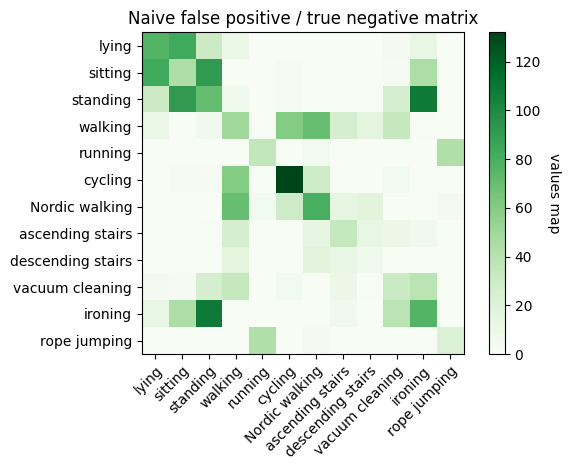

In [51]:
plot_matrix(protocol_activity_list, protocol_activity_list, matrix , 'Naive false positive / true negative matrix')

as expected we can see that our naive solution is indeed able to differentiate between the various activities we extracted features for.
Moreover, we can clearly see that the naive solution is better than randomized selection (8% prediction expected) 

## Fitting a classical machine learning model

In this section we've decided to use a Decision Tree Classifier model as our benchmark.
We will fit the model both to the raw data given by the sensors of the subjects and receive a prediction and to the extracted features we've used for our naive baseline solution.

In [52]:
clf = tree.DecisionTreeClassifier()

In [53]:
# Create a list containing only the dataframes we want to include
train_treedfs = [df for key, df in protocol_dataframes.items() if key != 'subject107' and key != 'subject108']
test_treedfs = [protocol_dataframes["subject107"], protocol_dataframes["subject108"]]

df_tree_train = pd.concat(train_treedfs, ignore_index=True)
df_tree_test = pd.concat(test_treedfs, ignore_index=True)

In [ ]:
time_start = time.time()
train_tree_dataset = activity_dataset(df_tree_train, window = 5000, prog_size = 1000)
test_tree_dataset = activity_dataset(df_tree_test, window = 5000, prog_size = 1000)
time_end = time.time()
print(f'Decision Tree dataset creation time: {time_end - time_start} seconds')

In [55]:
time_start = time.time()
clf.fit(train_tree_dataset.data, train_tree_dataset.labels)
time_end = time.time()
print(f'Decision Tree Fitting time: {time_end - time_start} seconds')

Decision Tree Fitting time: 98.91862559318542 seconds


In [62]:
time_start = time.time()
accuracy = clf.score(test_tree_dataset.data, test_tree_dataset.labels)
print(f'accuracy: {accuracy}')
time_end = time.time()
print(f'Decision Tree Prediction time: {time_end - time_start} seconds')

accuracy: 0.40003394776086226
Decision Tree Prediction time: 0.18223786354064941 seconds


In [84]:
matrix = [[0 for line in range(activity_amount)] for row in range(activity_amount)]
correct = 0
preds = clf.predict(test_tree_dataset.data)
for idx, pred in enumerate(preds):
    label = test_tree_dataset.labels[idx]
    update_matrix(matrix, get_index_from_activity_id(pred), get_index_from_activity_id(int(label)))

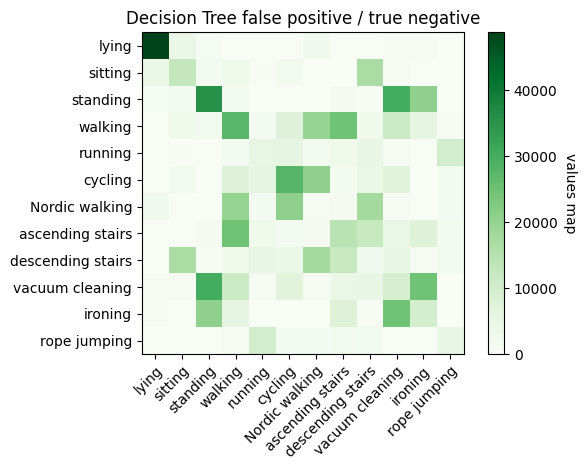

In [83]:
plot_matrix(protocol_activity_list, protocol_activity_list, matrix , 'Decision Tree false positive / true negative')

# Forming the neural network

## Common Functions and Config

In [85]:
batch_size = 32
loss_fn = nn.CrossEntropyLoss()

In [87]:
def train_and_validate_kfold(model, kfolds, epochs, batch_size, learning_rate, loss_fn): 
    model.to(device)
    model_history = []
    matrix = [[0 for line in range(activity_amount)] for row in range(activity_amount)]
    for fold, dataset in enumerate(kfolds.values()):
        time_start = time.time()
        train_dataset = dataset['Train']
        valid_dataset = dataset['Valid']
        print("fold number: " + str(fold+1))
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        current_history = []
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
        val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = True)
        for epoch in range(epochs):
            epoch_time_start = time.time()
            print("epoch: ", epoch+1, "/", epochs)
            train_loss, train_acc = train_loop(train_loader, model, device, loss_fn, optimizer)
            test_loss, test_acc = test_loop(val_loader, model, device, loss_fn, matrix)
            current_history.append({'train_loss':train_loss.detach().cpu().numpy(), 'val_loss':test_loss, 'train_acc':train_acc, 'val_acc':test_acc})
            epoch_time_end = time.time()
            print(f'epoch #{epoch+1} time to finish: {epoch_time_end - epoch_time_start } seconds')
            print()
        model_history.append(current_history)
        # Reset fold model weights after acquiring all relevant metrics
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        time_end = time.time()
        print(f'fold #{fold+1} time to finish: {time_end - time_start} seconds')
        plot_matrix(protocol_activity_list, protocol_activity_list, matrix , f'fold #{fold+1} false positive / true negative matrix')
    
    return model_history


In [88]:
def get_mean_history(model_history, fold_count):
    history = [{'train_loss':0, 'val_loss':0, 'train_acc':0, 'val_acc':0} for i in range(epochs)]
    for fold in range(fold_count):
        for epoch in range(epochs):
            history[epoch]['train_loss'] += model_history[fold][epoch]['train_loss']
            history[epoch]['val_loss'] += model_history[fold][epoch]['val_loss']
            history[epoch]['train_acc'] += model_history[fold][epoch]['train_acc']  
            history[epoch]['val_acc'] += model_history[fold][epoch]['val_acc']
    
    for epoch in range(epochs):
        history[epoch]['train_loss'] /= fold_count
        history[epoch]['val_loss'] /= fold_count
        history[epoch]['train_acc'] /= fold_count  
        history[epoch]['val_acc'] /= fold_count
    return history


In [89]:
def update_batch_on_matrix(matrix, pred, y):
    for idx, p in enumerate(pred): 
        update_matrix(matrix, int(p), int(y[idx]))

In [90]:
def train_loop(data_loader, model, device, loss_fn, optimizer, print_every_n=100):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    true_positives=0
    print_counter = 0
    for batch, (X,y) in enumerate(data_loader):
        print_counter +=1
        X = X.to(device)
        y = y.to(dtype=torch.long)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        if (print_counter * batch_size > 100000):
            print(batch * batch_size )
            print_counter = 0
        true_positives += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = loss.item()
    print(f'loss={loss:.3f} ')  
    train_loss /= num_batches
    train_acc = true_positives/size    
    print(f'train accuracy = {train_acc:.8f}')

    return train_loss, train_acc

def test_loop(data_loader, model, device, loss_fn, matrix):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0
    true_positives=0
    prev_print = 0
    with torch.no_grad():
        for idx, (X,y) in enumerate(data_loader):
            prev_print += 1
            if prev_print* batch_size > 100000:
                print(f'test finished {idx* batch_size} / {size}')
                prev_print = 0
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            update_batch_on_matrix(matrix, pred.argmax(1).tolist(), y.tolist())
            test_loss += loss_fn(pred,y).item()
            true_positives += (y==pred.argmax(1)).type(torch.float).sum().item()
        
    test_loss /= num_batches
    test_acc = true_positives/size
    print(f'test accuracy = {test_acc}, test loss = {test_loss:2f}')
    return test_loss, test_acc


## Version 1

### Version 1 Configurations

In [91]:
window_size = 50
stride = 30
input_size = df.drop(columns=columns_to_remove).columns.size
hidden_size = 50
learning_rate = 1e-4
epochs = 7

### Dataset creation

In [92]:
class lstm_dataset_v1(Dataset):
    def __init__(self, df, window = 5000, stride = 1000 , transform=None, target_transform=None, index_limit = -1):
        self.df = df
        if index_limit > -1:
            self.df = self.df[:index_limit]
        self.data = self.df.drop(columns=columns_to_remove)
        self.labels = df['activityID']
        self.window = window
        self.labels = df['activityID']
        self.stride = stride
        self.indexes = get_labels_index(self.df,self.window, self.stride)
        self.map_label_to_number =  map_labels_to_indexes(sorted(list(set(df['activityID']))))

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.indexes) 
    
    def __getitem__(self, idx):
        start, end ,org_label = self.indexes[idx]
        label = self.map_label_to_number[org_label]
        temp_df = (self.data).iloc[start:end]            
        x = self.data.iloc[start:end]
        x = torch.tensor((x.values).astype(np.float32))
        if self.transform:
            x = self.transform(temp_df)
        if self.target_transform:
            label = self.target_transform(label)
        return x, label


In [ ]:
kfolds_datasets = {}
for idx,model_dict in enumerate(kfolds.values()):
    print(f' creating Model #{idx+1} dataset')
    kfolds_datasets['Model ' +str(idx+1)] = {}
    train_ds = lstm_dataset_v1(model_dict['Train'],window = window_size  ,stride =  stride ) 
    kfolds_datasets['Model ' +str(idx+1)]['Train'] = train_ds
    valid_ds = lstm_dataset_v1(model_dict['Valid'],window = window_size  ,stride =  stride) 
    kfolds_datasets['Model ' +str(idx+1)]['Valid'] = valid_ds
    


### Model construction

In [94]:
class lstm_model_v1(nn.Module):
    def __init__(self,input_size ,hidden_size, classes_amount):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.fc = nn.Linear( hidden_size , classes_amount )
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden.squeeze_(0)
        x = self.fc(hidden)
        return x

lstm_model_v1 = lstm_model_v1(input_size, hidden_size,activity_amount )

### Fitting

fold number: 1
epoch:  1 / 7
loss=1.399 
train accuracy = 0.50603070
test accuracy = 0.4798076923076923, test loss = 1.787484
epoch #1 time to finish: 11.281605005264282 seconds

epoch:  2 / 7
loss=1.150 
train accuracy = 0.69663743
test accuracy = 0.5472902097902098, test loss = 1.537968
epoch #2 time to finish: 6.608651638031006 seconds

epoch:  3 / 7
loss=0.967 
train accuracy = 0.77241715
test accuracy = 0.5728146853146853, test loss = 1.433358
epoch #3 time to finish: 7.3536341190338135 seconds

epoch:  4 / 7
loss=0.549 
train accuracy = 0.80978923
test accuracy = 0.5851398601398602, test loss = 1.422755
epoch #4 time to finish: 6.689654588699341 seconds

epoch:  5 / 7
loss=0.726 
train accuracy = 0.83455166
test accuracy = 0.6009615384615384, test loss = 1.368279
epoch #5 time to finish: 6.681002855300903 seconds

epoch:  6 / 7
loss=0.566 
train accuracy = 0.85514133
test accuracy = 0.5977272727272728, test loss = 1.368043
epoch #6 time to finish: 6.653027296066284 seconds

epoch

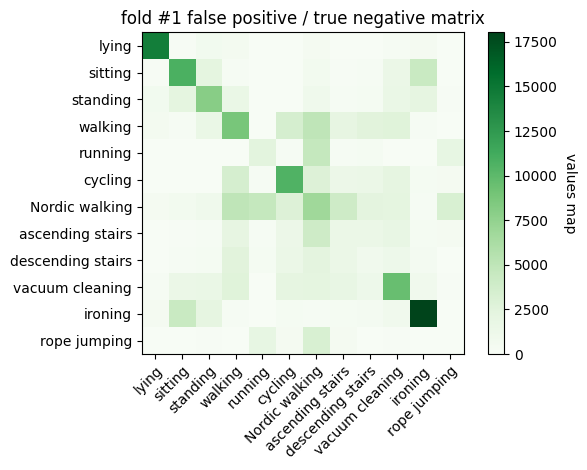

fold number: 2
epoch:  1 / 7
loss=2.251 
train accuracy = 0.48147387
test accuracy = 0.511003757380569, test loss = 1.698155
epoch #1 time to finish: 7.51234769821167 seconds

epoch:  2 / 7
loss=0.987 
train accuracy = 0.64349724
test accuracy = 0.6173435915786962, test loss = 1.322817
epoch #2 time to finish: 7.682792901992798 seconds

epoch:  3 / 7
loss=0.141 
train accuracy = 0.70625241
test accuracy = 0.6618357487922706, test loss = 1.120191
epoch #3 time to finish: 7.733558416366577 seconds

epoch:  4 / 7
loss=1.090 
train accuracy = 0.76358968
test accuracy = 0.6982167352537723, test loss = 1.006963
epoch #4 time to finish: 7.814417362213135 seconds

epoch:  5 / 7
loss=0.616 
train accuracy = 0.79627680
test accuracy = 0.7140812309894435, test loss = 0.961329
epoch #5 time to finish: 7.93212890625 seconds

epoch:  6 / 7
loss=0.070 
train accuracy = 0.82280139
test accuracy = 0.7292300351881672, test loss = 0.904215
epoch #6 time to finish: 7.689238786697388 seconds

epoch:  7 / 7

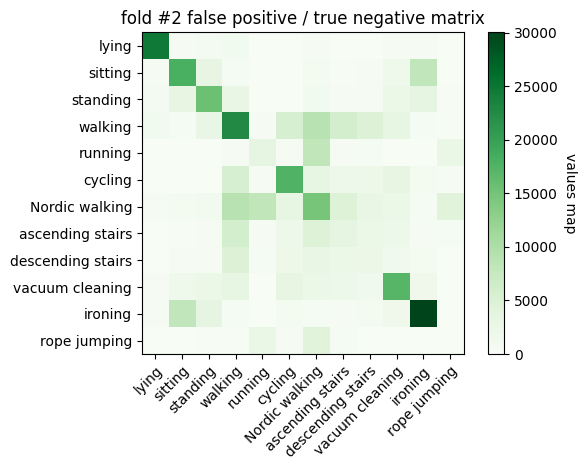

fold number: 3
epoch:  1 / 7
loss=1.790 
train accuracy = 0.46593689
test accuracy = 0.5386243386243387, test loss = 1.634346
epoch #1 time to finish: 7.770108938217163 seconds

epoch:  2 / 7
loss=1.283 
train accuracy = 0.62488965
test accuracy = 0.6344849050731404, test loss = 1.259376
epoch #2 time to finish: 7.813711881637573 seconds

epoch:  3 / 7
loss=0.692 
train accuracy = 0.70842687
test accuracy = 0.7045751633986929, test loss = 1.063573
epoch #3 time to finish: 6.99750018119812 seconds

epoch:  4 / 7
loss=0.912 
train accuracy = 0.76416879
test accuracy = 0.734640522875817, test loss = 0.931025
epoch #4 time to finish: 7.098841905593872 seconds

epoch:  5 / 7
loss=0.690 
train accuracy = 0.80134689
test accuracy = 0.7574852163087458, test loss = 0.854615
epoch #5 time to finish: 6.966885328292847 seconds

epoch:  6 / 7
loss=0.595 
train accuracy = 0.82881429
test accuracy = 0.7759726112667289, test loss = 0.785731
epoch #6 time to finish: 6.866876125335693 seconds

epoch:  7

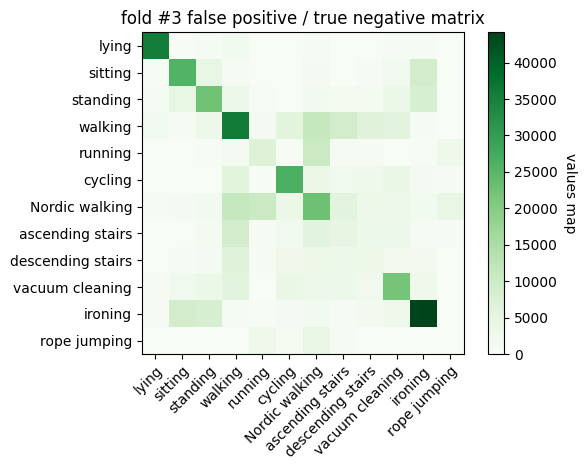

In [96]:
model_history = train_and_validate_kfold(lstm_model_v1, kfolds_datasets, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

### Plots

In [97]:
history = get_mean_history(model_history, kfolds_count)

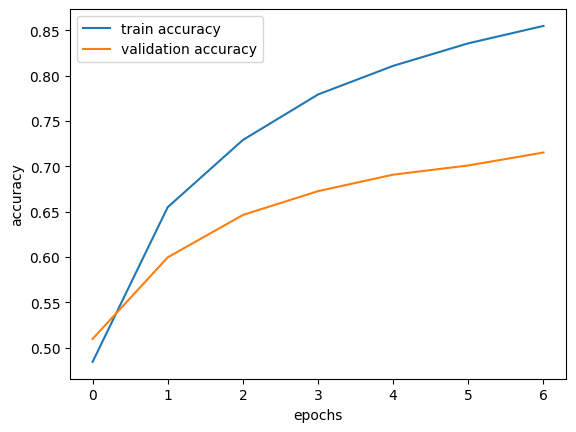

In [98]:
plot_accuracy(epochs, history)

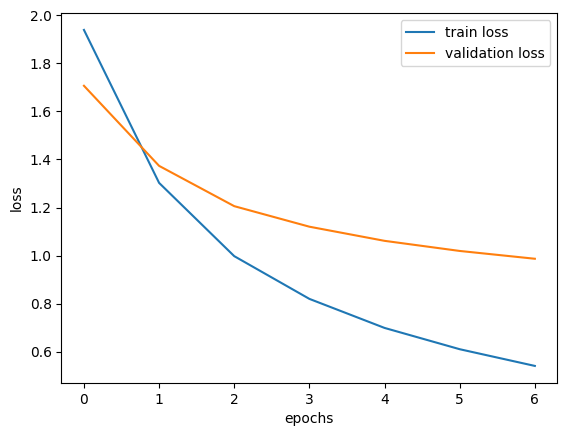

In [99]:
plot_loss(epochs, history)

In [100]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,1.939056,1.706662,0.484480,0.509812
1,1.302537,1.373387,0.655008,0.599706
2,0.997647,1.205707,0.729032,0.646409
3,0.819859,1.120248,0.779183,0.672666
4,0.699031,1.061408,0.810725,0.690843
5,0.610450,1.019330,0.835586,0.700977
6,0.540926,0.986867,0.854734,0.715233


### model Performance Conclusions

we can see the model is doing well. reaching roughly 72% validation accuracy.
we suggest the next reasons for the model's success:
* targeting the relevant features after researching and understanding of the data behavior during exploritory of the data analysis 
* creation of naive and solid benchmarks helped us to understand what are the important features and understading the meaning of configurations such as the ratio between window size and stride. by that we chose a good ratio over stride and window size. 
* data indexing and window creation ensured each sequence provided to the model without overlapping between activities


### Ideas to Improve
as we got the result of:
* overfitting -  we can see train accuracy is getting heighr while validation accuracy is remaining low.
* we can understand from the naive solution that we need to take the change in the measurements into consideration. because the window is small - we take in consideration only a small fraction of the values representing the entire measurements. 
* we have a small amount of subjects, therefore the model has trouble in generalizing the input for an arbitrary subject. Moreover, the model may learn a subject's specific patterns and one's specific measurement values and get into overfit. 
* The model did not convergent 

solutions:
* we can take the feature we extracted in the naive solution as they would give a good predition as a freatures to the fully connected layer
* we can use dropouts to avoid overfitting
* increase window and skip measures in order to gain the change in measures and avoid overfitting over a subject
* change learning rate for a better convergence result
* number of epochs should be increased in order to reach convergance

## Version 2

### Version 2 Configurations

In [101]:
window_size = 2000
stride = 200
input_size = df.drop(columns=columns_to_remove).columns.size
hidden_size = 50
learning_rate = 1e-4
epochs = 25
dropout_count = 3

### Dataset creation

In [102]:
class lstm_dataset_v2(Dataset):
    def __init__(self, df, window = 5000, stride = 1000 , transform=None, target_transform=None, index_limit = -1):
        self.df = df
        if index_limit > -1:
            self.df = self.df[:index_limit]
        self.data = self.df.drop(columns=columns_to_remove)
        self.labels = df['activityID']
        self.window = window
        self.labels = df['activityID']
        self.stride = stride
        self.indexes = get_labels_index(self.df,self.window, self.stride)
        self.map_label_to_number = map_labels_to_indexes(sorted(list(set(df['activityID']))))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.indexes) 
    
    def __getitem__(self, idx):
        start, end ,org_label = self.indexes[idx]
        label = self.map_label_to_number[org_label]
        temp_df = (self.data).iloc[start:end]
        x = self.data.iloc[start:end]
        x = torch.tensor((x.values).astype(np.float32))
        if self.transform:
            x = self.transform(temp_df)
        if self.target_transform:
            label = self.target_transform(label)
        return  x, label

    

In [ ]:
kfolds_datasets = {}
for idx,model_dict in enumerate(kfolds.values()):
    print(f' creating Model #{idx+1} dataset')
    kfolds_datasets['Model ' +str(idx+1)] = {}
    train_ds = lstm_dataset_v2(model_dict['Train'],window = window_size  ,stride =  stride ) 
    kfolds_datasets['Model ' +str(idx+1)]['Train'] = train_ds
    valid_ds = lstm_dataset_v2(model_dict['Valid'],window = window_size  ,stride =  stride) 
    kfolds_datasets['Model ' +str(idx+1)]['Valid'] = valid_ds

### Model Construction

In [104]:
class lstm_model_v2(nn.Module):
    def __init__(self,input_size ,hidden_size, classes_amount):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.fc = nn.Linear( hidden_size , classes_amount )
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden.squeeze_(0)
        x = self.fc(hidden)
        return x

activity_amount = len(set(df['activityID']))
model_v2 = lstm_model_v2(input_size, hidden_size,activity_amount )

### Fitting

fold number: 1
epoch:  1 / 25
loss=2.363 
train accuracy = 0.12576065
test accuracy = 0.1685686338441474, test loss = 2.389045
epoch #1 time to finish: 4.8229100704193115 seconds

epoch:  2 / 25
loss=2.115 
train accuracy = 0.34527834
test accuracy = 0.35604825562438863, test loss = 2.243617
epoch #2 time to finish: 6.201827049255371 seconds

epoch:  3 / 25
loss=1.926 
train accuracy = 0.41672301
test accuracy = 0.37887186175415716, test loss = 2.113881
epoch #3 time to finish: 5.321230888366699 seconds

epoch:  4 / 25
loss=1.973 
train accuracy = 0.48636466
test accuracy = 0.4254972285621128, test loss = 1.997112
epoch #4 time to finish: 3.6670663356781006 seconds

epoch:  5 / 25
loss=1.863 
train accuracy = 0.58598152
test accuracy = 0.49168568633844145, test loss = 1.896628
epoch #5 time to finish: 3.6107053756713867 seconds

epoch:  6 / 25
loss=1.343 
train accuracy = 0.66035610
test accuracy = 0.5464623410498859, test loss = 1.806819
epoch #6 time to finish: 3.7149176597595215 sec

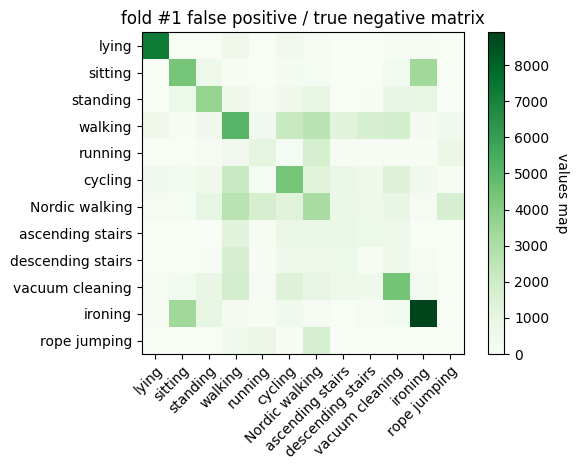

fold number: 2
epoch:  1 / 25
loss=2.216 
train accuracy = 0.21326199
test accuracy = 0.31968295904887717, test loss = 2.328619
epoch #1 time to finish: 4.1098716259002686 seconds

epoch:  2 / 25
loss=1.964 
train accuracy = 0.41792471
test accuracy = 0.4002642007926024, test loss = 2.124193
epoch #2 time to finish: 4.085561037063599 seconds

epoch:  3 / 25
loss=1.889 
train accuracy = 0.51309001
test accuracy = 0.4579480405107882, test loss = 1.961876
epoch #3 time to finish: 4.032331705093384 seconds

epoch:  4 / 25
loss=1.871 
train accuracy = 0.58360405
test accuracy = 0.5605460149713782, test loss = 1.818661
epoch #4 time to finish: 6.395204305648804 seconds

epoch:  5 / 25
loss=1.492 
train accuracy = 0.63367093
test accuracy = 0.5931307793923382, test loss = 1.686355
epoch #5 time to finish: 4.040958881378174 seconds

epoch:  6 / 25
loss=1.676 
train accuracy = 0.68106249
test accuracy = 0.6420079260237781, test loss = 1.563753
epoch #6 time to finish: 3.8351848125457764 seconds

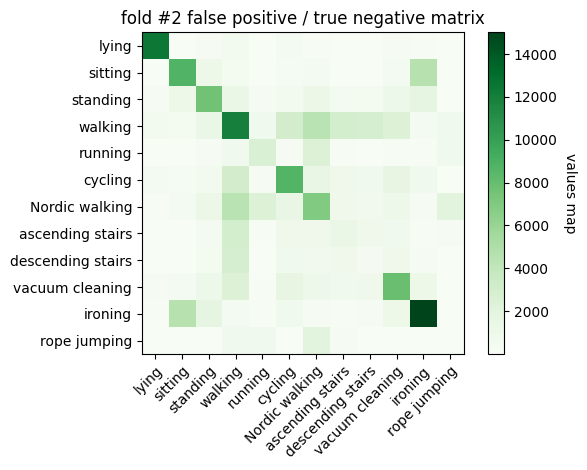

fold number: 3
epoch:  1 / 25
loss=2.260 
train accuracy = 0.17740727
test accuracy = 0.3541089566020314, test loss = 2.262269
epoch #1 time to finish: 4.204208135604858 seconds

epoch:  2 / 25
loss=2.151 
train accuracy = 0.40989135
test accuracy = 0.474145891043398, test loss = 2.069828
epoch #2 time to finish: 3.989422559738159 seconds

epoch:  3 / 25
loss=1.860 
train accuracy = 0.48557512
test accuracy = 0.5369344413665743, test loss = 1.895711
epoch #3 time to finish: 4.1638617515563965 seconds

epoch:  4 / 25
loss=1.962 
train accuracy = 0.53821656
test accuracy = 0.5577100646352724, test loss = 1.775753
epoch #4 time to finish: 6.3386077880859375 seconds

epoch:  5 / 25
loss=1.578 
train accuracy = 0.58523792
test accuracy = 0.5789473684210527, test loss = 1.618911
epoch #5 time to finish: 3.9623351097106934 seconds

epoch:  6 / 25
loss=1.362 
train accuracy = 0.61464968
test accuracy = 0.5881809787626963, test loss = 1.521816
epoch #6 time to finish: 4.003235578536987 seconds


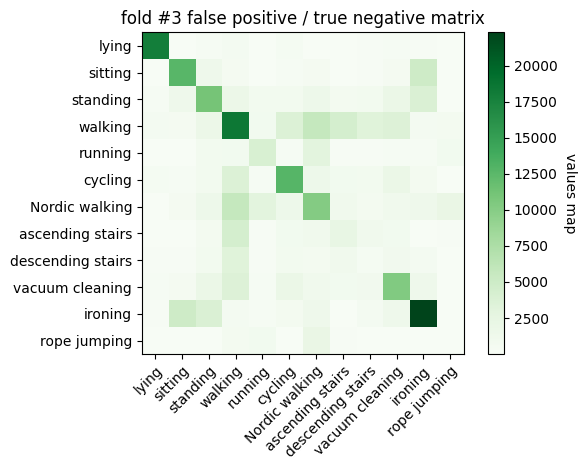

In [105]:
model_history = train_and_validate_kfold(model_v2, kfolds_datasets, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

### Plots

In [106]:

history = get_mean_history(model_history, kfolds_count)


In [115]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,2.407642,2.326645,0.172143,0.280787
1,2.188471,2.145879,0.391031,0.410153
2,1.998737,1.990489,0.471796,0.457918
3,1.834289,1.863842,0.536062,0.514584
4,1.691402,1.733965,0.601630,0.554588
5,1.552094,1.630796,0.652023,0.592217
6,1.431248,1.528698,0.687788,0.624692
7,1.323055,1.459890,0.716349,0.632893
8,1.229271,1.388529,0.739096,0.655708
9,1.141797,1.317297,0.764072,0.664945


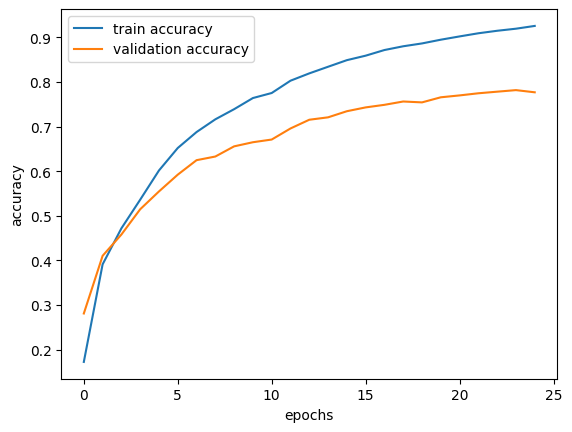

In [107]:
plot_accuracy(epochs, history)

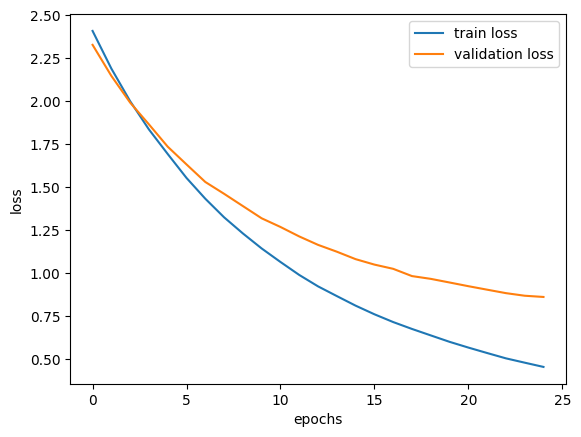

In [108]:
plot_loss(epochs, history)

### model Performance Conclusions

we can see the model is doing well. reaching roughly 78% validation accuracy.
we suggest the next reasons for the model's success:
* Increasing the window's size allows us to measure data that is changing over a larger period of time and take that into consideration so the model will be able to generalize patterns for activities with this sort of behavior
* decreasing learning rate allowed the model to settle on a better local minimum than the previous version.


### Ideas to Improve
as we got the result of:
* misclassifying walking activity

solutions:
* dropout - although our solution is reaching a high preformence and is not necessarly overfitting, dropout may allow us to generalize our input better.
* Inserting extracted feature from the naive solution as an additional features to the fully connected layer would help us to classify walking activity, as the naive solution was a good classifier for the walking activity.
* Skip every 2nd measure in order to increase the window size even more.

# Final Version

we will take the second version of our LSTM model.
In addition we will create a dataset of train and test only, without validation, in order to measure our final metrics.
As mentions before, our test comprises of subjet 107, subject 108. data we haven't seen before.

In [109]:
window_size = 2000
stride = 200
input_size = df.drop(columns=columns_to_remove).columns.size
hidden_size = 50
learning_rate = 9.99e-3
epochs = 12
dropout_count = 5

In [110]:
# Create a list containing only the dataframes we want to include
final_train_dfs = [df for key, df in protocol_dataframes.items() if key != 'subject107' and key != 'subject108']
final_test_dfs = [protocol_dataframes["subject107"], protocol_dataframes["subject108"]]

df_final_train = pd.concat(final_train_dfs, ignore_index=True)
df_final_test = pd.concat(final_test_dfs, ignore_index=True)

In [ ]:
final_train_dataset = lstm_dataset_v2(df_final_train ,window = window_size  ,stride =  stride ) 
final_test_dataset = lstm_dataset_v2(df_final_test ,window = window_size  ,stride =  stride ) 

In [118]:
def train_and_test(model, train_dataset, test_dataset, epochs, batch_size, learning_rate, loss_fn, only_train = False):
    train_time = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    matrix = [[0 for line in range(activity_amount)] for row in range(activity_amount)]
    if not only_train:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        print("epoch: ", epoch+1, "/", epochs)
        time_start = time.time()
        train_loss, train_acc = train_loop(train_loader, model, device, loss_fn, optimizer)
        time_end = time.time()
        train_time += time_end - time_start
        print(f'final model train time: {time_end - time_start} seconds')
        print()
    
    if not only_train:
        test_loss, test_acc = test_loop(test_loader, model, device, loss_fn, matrix)
        print(f'final model test time: {time_end - time_start} seconds')
        plot_matrix(protocol_activity_list, protocol_activity_list, matrix , 'Naive false positive / true negative matrix')

    
    print(f'final model train time: {train_time} seconds')
    
    return history

In [119]:
activity_amount = len(set(df['activityID']))
final_model = lstm_model_v2(input_size, hidden_size,activity_amount )
final_model.to(device)

lstm_model_v2(
  (lstm): LSTM(31, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=12, bias=True)
)

epoch:  1 / 12
loss=0.522 
train accuracy = 0.68094945
final model train time: 3.9587042331695557 seconds

epoch:  2 / 12
loss=0.433 
train accuracy = 0.87114673
final model train time: 5.933189630508423 seconds

epoch:  3 / 12
loss=0.072 
train accuracy = 0.92540074
final model train time: 4.5735087394714355 seconds

epoch:  4 / 12
loss=0.162 
train accuracy = 0.94312577
final model train time: 4.725949048995972 seconds

epoch:  5 / 12
loss=0.082 
train accuracy = 0.94343403
final model train time: 4.405638694763184 seconds

epoch:  6 / 12
loss=0.136 
train accuracy = 0.96686190
final model train time: 4.14460563659668 seconds

epoch:  7 / 12
loss=0.712 
train accuracy = 0.95961776
final model train time: 4.237751722335815 seconds

epoch:  8 / 12
loss=0.390 
train accuracy = 0.95915536
final model train time: 4.25767707824707 seconds

epoch:  9 / 12
loss=0.190 
train accuracy = 0.96115906
final model train time: 4.8223865032196045 seconds

epoch:  10 / 12
loss=0.196 
train accuracy = 

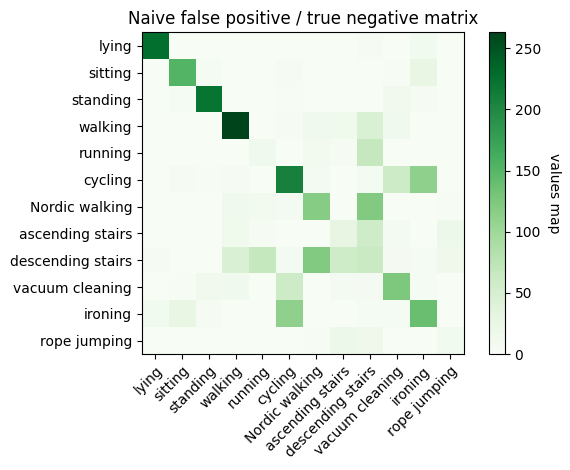

final model train time: 53.8675217628479 seconds


In [120]:
history = train_and_test(final_model, final_train_dataset, final_test_dataset, epochs, batch_size, learning_rate, loss_fn)

we can see the test reached almost identical accuracy to the validation. by that we can see we chose a good validation metrics.

# Self Supervised

we decided to pretrain our model over classify the subject in perform.
Therefore, we will have to change the dataset. that label should be the subject's name

## Dataset Creation

In [122]:
class pretrained_ds(Dataset):
    def __init__(self, df, window = 5000, stride = 1000 , transform=None, target_transform=None, index_limit = -1):
        self.df = df
        if index_limit > -1:
            self.df = self.df[:index_limit]
        self.data = self.df.drop(columns=columns_to_remove)
        self.window = window
        self.labels = df['subject']
        self.stride = stride
        self.indexes = get_labels_index(self.df,self.window, self.stride,label_gained = 'subject' )
        self.map_label_to_number = map_labels_to_indexes(sorted(list(set(df['subject']))))

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.indexes) 
    
    def __getitem__(self, idx):
        start, end ,org_label = self.indexes[idx]
        label = self.map_label_to_number[org_label]
        temp_df = (self.data).iloc[start:end]
        x = self.data.iloc[start:end]
        x = torch.tensor((x.values).astype(np.float32))
        if self.transform:
            x = self.transform(temp_df)
        if self.target_transform:
            label = self.target_transform(label)
        return  x, label

    

In [123]:
subjects_list = ['subject101','subject102','subject103','subject104','subject105', 'subject106','subject109']
dataframes = [df[df['subject'] == s] for s in subjects_list]
train_dataframe = pd.concat(dataframes, ignore_index = True)
subjects_list = ['subject107','subject108']
dataframes = [df[df['subject'] == s] for s in subjects_list]
test_dataframe = pd.concat(dataframes, ignore_index = True)


In [ ]:
pretrained_train_dataset = pretrained_ds(train_dataframe ,window = window_size  ,stride =  stride) 
pretrained_test_dataset = pretrained_ds(test_dataframe ,window = window_size  ,stride =  stride ) 

## Model Construction

In [125]:
class pretained_lstm(nn.Module):
    def __init__(self,input_size ,hidden_size, classes_amount):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.fc = nn.Linear( hidden_size , classes_amount )
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden.squeeze_(0)
        x = self.fc(hidden)
        return x

subjects_amount = len(set(df['subject']))
pretrained_model = pretained_lstm(input_size, hidden_size,subjects_amount )
pretrained_model.to(device)

pretained_lstm(
  (lstm): LSTM(31, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=9, bias=True)
)

In [126]:
history = train_and_test(pretrained_model, pretrained_train_dataset, pretrained_test_dataset, epochs, batch_size, learning_rate, loss_fn , only_train = True)

epoch:  1 / 12
loss=1.175 
train accuracy = 0.42255681
final model train time: 4.795367240905762 seconds

epoch:  2 / 12
loss=0.849 
train accuracy = 0.51191970
final model train time: 5.38811731338501 seconds

epoch:  3 / 12
loss=1.336 
train accuracy = 0.55151262
final model train time: 6.4999542236328125 seconds

epoch:  4 / 12
loss=1.149 
train accuracy = 0.57298202
final model train time: 5.847337007522583 seconds

epoch:  5 / 12
loss=1.352 
train accuracy = 0.58817789
final model train time: 5.349176645278931 seconds

epoch:  6 / 12
loss=0.887 
train accuracy = 0.61843022
final model train time: 4.8920581340789795 seconds

epoch:  7 / 12
loss=0.459 
train accuracy = 0.66499373
final model train time: 4.983553886413574 seconds

epoch:  8 / 12
loss=0.987 
train accuracy = 0.64589433
final model train time: 5.124262571334839 seconds

epoch:  9 / 12
loss=0.655 
train accuracy = 0.66290255
final model train time: 6.28519606590271 seconds

epoch:  10 / 12
loss=1.309 
train accuracy = 0

## Redefine model class prediction and train

In [127]:
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(pretrained_model, feature_extract)
pretrained_model.fc = nn.Linear( hidden_size , activity_amount )
pretrained_model.to(device)

pretained_lstm(
  (lstm): LSTM(31, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=12, bias=True)
)

In [128]:
def train(model, dataset, epochs, batch_size, learning_rate, loss_fn): 
    history = []
    train_subsampler = torch.utils.data.SubsetRandomSampler([i for i in range(dataset.__len__())])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler= train_subsampler)
    for epoch in range(epochs):
        print("epoch: ", epoch+1, "/", epochs)
        train_loss, train_acc = train_loop(train_loader, model, device, loss_fn, optimizer)
        history.append({'train_loss':train_loss.detach().cpu().numpy(), 'train_acc':train_acc})

        print()

    return history
history = train(pretrained_model, final_train_dataset, epochs=6, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

epoch:  1 / 6
loss=1.703 
train accuracy = 0.44697904

epoch:  2 / 6
loss=1.401 
train accuracy = 0.52419852

epoch:  3 / 6
loss=1.572 
train accuracy = 0.54254007

epoch:  4 / 6
loss=0.981 
train accuracy = 0.54623921

epoch:  5 / 6
loss=1.367 
train accuracy = 0.55332922

epoch:  6 / 6
loss=1.625 
train accuracy = 0.55733662



## Fine Tunning

In [129]:
num_epochs = 6
for param in pretrained_model.parameters():
    param.requires_grad = True
history = train(pretrained_model, final_train_dataset, epochs=num_epochs, batch_size=batch_size, learning_rate=5e-3, loss_fn=loss_fn)

epoch:  1 / 6
loss=0.892 
train accuracy = 0.61266954

epoch:  2 / 6
loss=0.937 
train accuracy = 0.67632552

epoch:  3 / 6
loss=0.671 
train accuracy = 0.74429716

epoch:  4 / 6
loss=0.529 
train accuracy = 0.80302096

epoch:  5 / 6
loss=0.389 
train accuracy = 0.83631319

epoch:  6 / 6
loss=0.330 
train accuracy = 0.86451911



In [131]:
matrix = [[0 for line in range(activity_amount)] for row in range(activity_amount)]
test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=True)
test_loss, test_acc = test_loop(test_loader, pretrained_model, device, loss_fn, matrix)

test accuracy = 0.5854758682904826, test loss = 1.888565


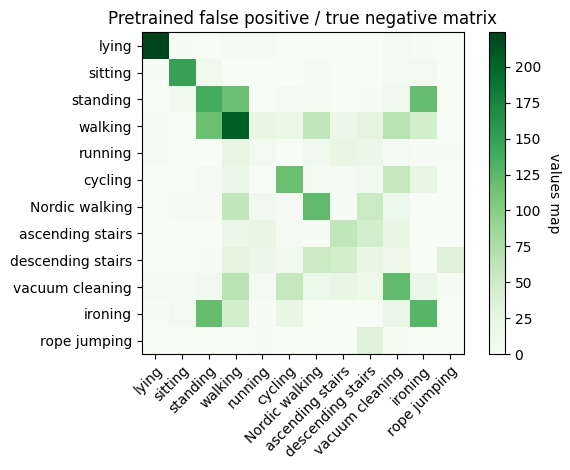

In [133]:
plot_matrix(protocol_activity_list, protocol_activity_list, matrix , 'Pretrained false positive / true negative matrix')